#### BIBLIOTECAS

In [4]:
import unidecode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from wordcloud import WordCloud
from nltk import tokenize
import nltk
from string import punctuation
from nltk import ngrams
import joblib

#### BASE DE DADOS DE TREINO E TESTE

In [5]:
# Acessando dados de filmes classificados como positivos e negativos
resenha = pd.read_csv('imdb-reviews-pt-br.csv')

In [7]:
# Criando a coluna de classficiação usando 0 para negativo e 1 para positivo
classificacao = resenha["sentiment"].replace(["neg", "pos"], [0, 1])

resenha["classificacao"] = classificacao
resenha.head()

C:\Users\marco\AppData\Local\Temp\ipykernel_23204\1158911383.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  classificacao = resenha["sentiment"].replace(["neg", "pos"],[0, 1])


,id,text_en,text_pt,sentiment,classificacao
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0


In [8]:
# Verificar se a base e está balanceada
print(resenha["classificacao"].value_counts())

# Posteriormente realizar um bancelamento exato dos dados para ver se acontece alguma diferença.

classificacao
0    24765
1    24694
Name: count, dtype: int64


#### TRATAMENTO DOS DADOS

O modelo saco-de-palavras é uma representação simplificada utilizada no processamento de linguagem natural, atraves de números e vetores.

In [9]:
# Vetorizar os dados com a CountVectorizer da sklearn
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
# Utilizando o parâmetro max_features, para criar um vetor do tamanho que quisermos, para evitar processar tudo e consumir muita memoria
# **** é suficiente para a quantidade de dados
vetorizar = CountVectorizer(lowercase=False, max_features=50)
bag_of_words = vetorizar.fit_transform(resenha["text_pt"])

In [ ]:
print(bag_of_words)

In [13]:
# Criar DataFrame esparsa
matriz_esparsa2 = pd.DataFrame.sparse.from_spmatrix(bag_of_words,
                                                    columns=vetorizar.get_feature_names_out())

In [14]:
matriz_esparsa2

,Eu,ao,apenas,as,com,como,da,de,do,dos,...,seu,sobre,sua,são,também,tem,tão,um,uma,você
0,0,1,0,0,2,1,0,4,4,2,...,1,1,0,0,0,1,0,3,2,0
1,0,0,0,0,2,0,0,7,1,2,...,1,0,0,2,0,1,0,4,2,1
2,1,0,0,0,3,1,0,10,2,0,...,0,0,0,3,1,0,1,3,2,2
3,2,0,1,4,7,2,1,13,3,1,...,0,0,0,1,0,1,0,7,4,1
4,0,0,1,2,3,0,1,16,2,1,...,0,0,0,4,0,0,0,3,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49454,0,2,0,0,0,1,1,5,1,0,...,0,0,1,0,0,0,0,2,1,0
49455,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,1,0
49456,1,0,0,1,3,8,1,14,8,4,...,1,0,1,4,0,1,1,12,3,2
49457,1,0,0,2,2,1,1,5,1,2,...,0,0,0,0,3,0,0,4,1,2


Regressão logística é um modelo de aprendizado de máquina que é usado para prever uma variável categórica, como "sim" ou "não", "aceito" ou "rejeitado", "doente" ou "saudável". A regressão logística é uma técnica probabilística, o que significa que ela retorna uma probabilidade para cada classe.

In [15]:
# Separando meus dados em dados de teste e dados de treino ()
from sklearn.model_selection import train_test_split

# Se não passarmos os parametros de valores de treino e teste, por padrão é 75% de treino e 25% de teste
treino, teste, classe_treino, classe_teste = train_test_split(bag_of_words,
                                                              resenha["classificacao"],
                                                              random_state=42)

#

In [ ]:
# Usando a regressão logistica para criar o modelo
from sklearn.linear_model import LogisticRegression

regressao_logistica = LogisticRegression(solver="lbfgs")
regressao_logistica.fit(treino, classe_treino)
previsao_teste = regressao_logistica.predict_proba(teste)

In [18]:
# Calculando acuracia
regressao_logistica = LogisticRegression()
regressao_logistica.fit(treino, classe_treino)
acuracia1 = regressao_logistica.score(teste, classe_teste)
print(acuracia1)

0.6583097452486858


In [21]:
# Criando a função para classificação de sentimentos

def classificar_texto(texto, coluna_texto, coluna_classificacao):
    vetorizar = CountVectorizer(lowercase=False, max_features=50)
    bag_of_words = vetorizar.fit_transform(texto[coluna_texto])
    treino, teste, classe_treino, classe_teste = train_test_split(bag_of_words,
                                                                  texto[coluna_classificacao],
                                                                  random_state=42)
    regressao_logistica = LogisticRegression(solver="lbfgs")
    regressao_logistica.fit(treino, classe_treino)
    return regressao_logistica.score(teste, classe_teste)


print(classificar_texto(resenha, "text_pt", "classificacao"))

0.6583097452486858


#### TRATAMENTO DE DADOS 1

Wordcloud: Nuvem de palavras: Para melhorar nossos dados, eliminando palavras sem nexo para as analises

In [22]:
%matplotlib inline

from wordcloud import WordCloud

todos_palavras = ' '.join([texto for texto in resenha["text_pt"]])

In [23]:
nuvem_palavras = WordCloud(width=800, height=500, max_font_size=110,
                           collocations=False).generate(todos_palavras)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.axis('off')
plt.show()

In [26]:
# Nuvem para classificação positiva
def nuvem_palavras_pos(texto, coluna_texto):
    texto_positivo = texto.query("sentiment == 'pos'")
    todas_palavras = ' '.join(
        [texto for texto in texto_positivo[coluna_texto]])

    nuvem_palavras = WordCloud(width=800, height=500,
                               max_font_size=110,
                               collocations=False).generate(todas_palavras)
    plt.figure(figsize=(10, 7))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis("off")
    plt.show()

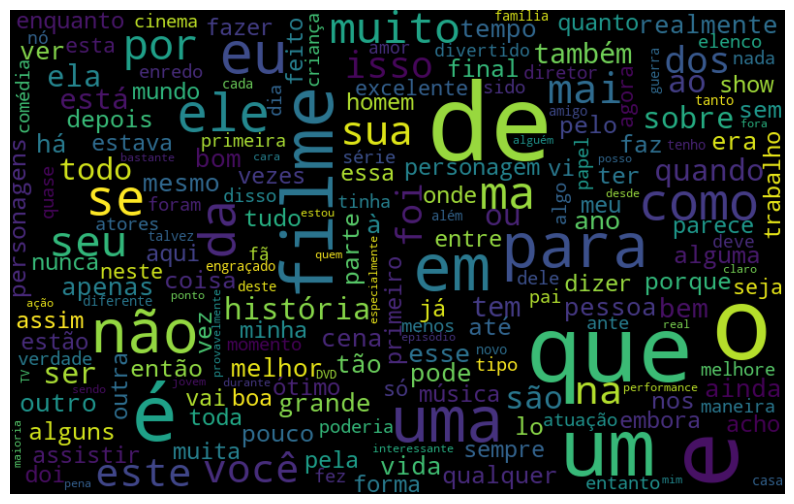

In [27]:
nuvem_palavras_pos(resenha, "text_pt")

In [28]:
# Nuvem para classificação negativa
def nuvem_palavras_neg(texto, coluna_texto):
    texto_negativo = texto.query("sentiment == 'neg'")
    todas_palavras = ' '.join(
        [texto for texto in texto_negativo[coluna_texto]])

    nuvem_palavras = WordCloud(width=800, height=500,
                               max_font_size=110,
                               collocations=False).generate(todas_palavras)
    plt.figure(figsize=(10, 7))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis("off")
    plt.show()

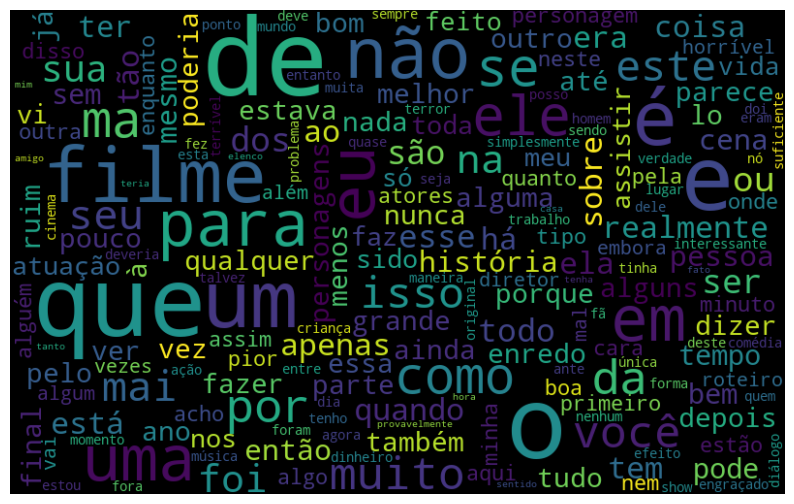

In [29]:
nuvem_palavras_neg(resenha, "text_pt")

#### LIMPEZA DE DADOS 2
Tokenização com NLTK para criar uma nova visualização em quantidade de repetições por palavras e ajudar a entender o que precisa ser desconsiderado na analise

In [30]:
from nltk import tokenize
import nltk

In [31]:
todas_palavras = ' '.join([texto for texto in resenha["text_pt"]])
token_espaco = tokenize.WhitespaceTokenizer()
token_frase = token_espaco.tokenize(todas_palavras)
frequencia = nltk.FreqDist(token_frase)

In [32]:
token_frase = token_espaco.tokenize(todas_palavras)
frequencia = nltk.FreqDist(token_frase)
df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                              "Frequência": list(frequencia.values())})

In [33]:
df_frequencia.head()

,Palavra,Frequência
0,Mais,1538
1,uma,130888
2,"vez,",1927
3,o,244881
4,Sr.,1741
...,...,...
348280,"Muppified,",1
348281,inventora,1
348282,"""Union",1
348283,beirar,1


In [35]:
# Visualizando as 10 maiores
df_frequencia = df_frequencia.nlargest(columns="Frequência", n=10)
df_frequencia

,Palavra,Frequência
20,de,417651
14,que,325070
42,e,299743
3,o,244881
7,um,216410
102,a,210179
45,é,192381
200,em,132778
1,uma,130888
29,não,127915


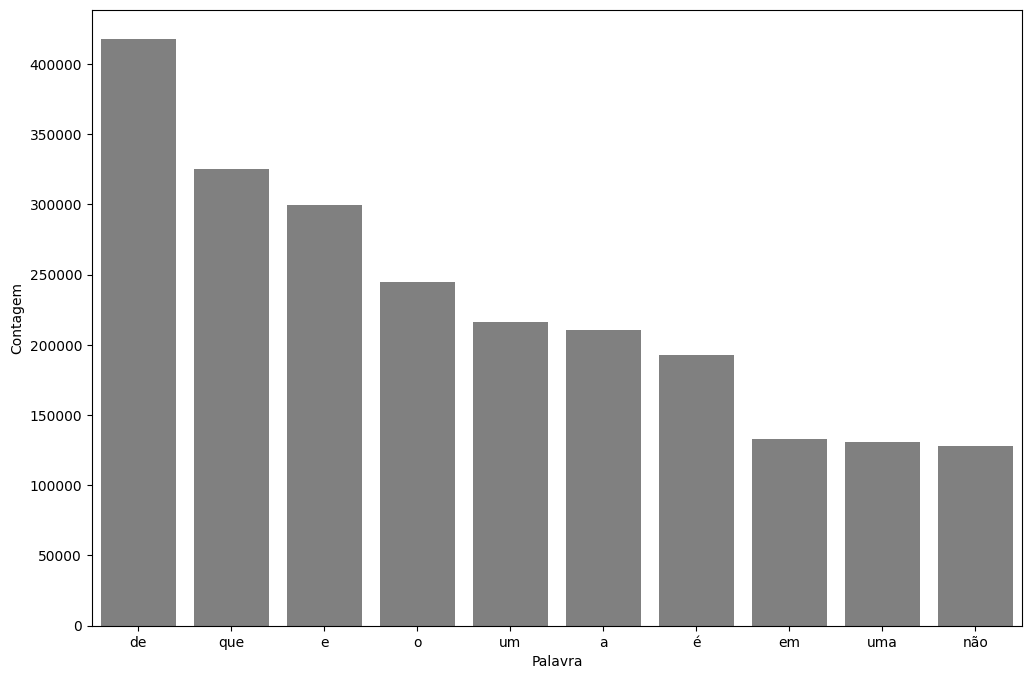

In [36]:
# Criando uma visualização das frequencias de palavras em gráfico de barras, criando uma função:
import seaborn as sns


def pareto(texto, coluna_texto, quantidade):
    todas_palavras = ' '.join([texto for texto in texto[coluna_texto]])
    token_frase = token_espaco.tokenize(todas_palavras)
    frequencia = nltk.FreqDist(token_frase)
    df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                                  "Frequência": list(frequencia.values())})
    df_frequencia = df_frequencia.nlargest(columns="Frequência", n=quantidade)
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=df_frequencia, x="Palavra",
                     y="Frequência", color='gray')
    ax.set(ylabel="Contagem")
    plt.show()


pareto(resenha, "text_pt", 10)

Removendo palavras que não agrega com a nltk.corpus.stopwords.words, que é uma uma lista com esses dados

In [37]:
nltk.download('stopwords')
palavras_irrelevantes = nltk.corpus.stopwords.words("portuguese")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [38]:
# Separar palavra por paalavra em uma lista, para abalisar e depois colocar em uma coluna nova no df resenha
frase_processada = list()
for opiniao in resenha.text_pt:
    nova_frase = list()
    palavras_texto = token_espaco.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in palavras_irrelevantes:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))

resenha["tratamento_1"] = frase_processada

In [39]:
resenha.head()

,id,text_en,text_pt,sentiment,classificacao,tratamento_1
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0,"Mais vez, Sr. Costner arrumou filme tempo nece..."
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0,Este exemplo motivo maioria filmes ação mesmos...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0,"Primeiro tudo odeio raps imbecis, poderiam agi..."
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0,Nem Beatles puderam escrever músicas todos gos...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0,"Filmes fotos latão palavra apropriada eles, ve..."


In [40]:
# Verificando acuracia com esse tratamento
acuracia2 = classificar_texto(resenha, "tratamento_1", "classificacao")
print(acuracia2)
print(acuracia1)

0.6810351799433886
0.6583097452486858


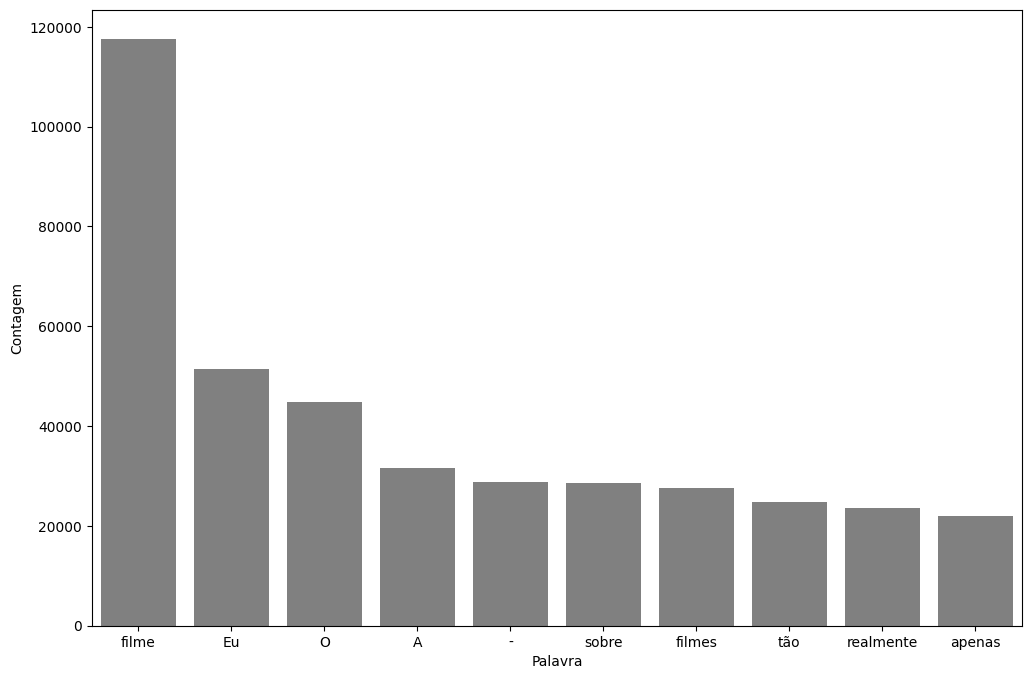

In [41]:
pareto(resenha, "tratamento_1", 10)

In [42]:
# Retirar pontuações
from nltk import tokenize

frase = "Olá mundo!"
token_pontuacao = tokenize.WordPunctTokenizer()
token_frase = token_pontuacao.tokenize(frase)

print(token_frase)

['Olá', 'mundo', '!']


In [43]:
# Retirar pontuações

from string import punctuation

pontuacao = list()
for ponto in punctuation:
    pontuacao.append(ponto)

pontuacao_stopwords = pontuacao + palavras_irrelevantes

frase_processada = list()
for opiniao in resenha["tratamento_1"]:
    nova_frase = list()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in pontuacao_stopwords:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))

resenha["tratamento_2"] = frase_processada

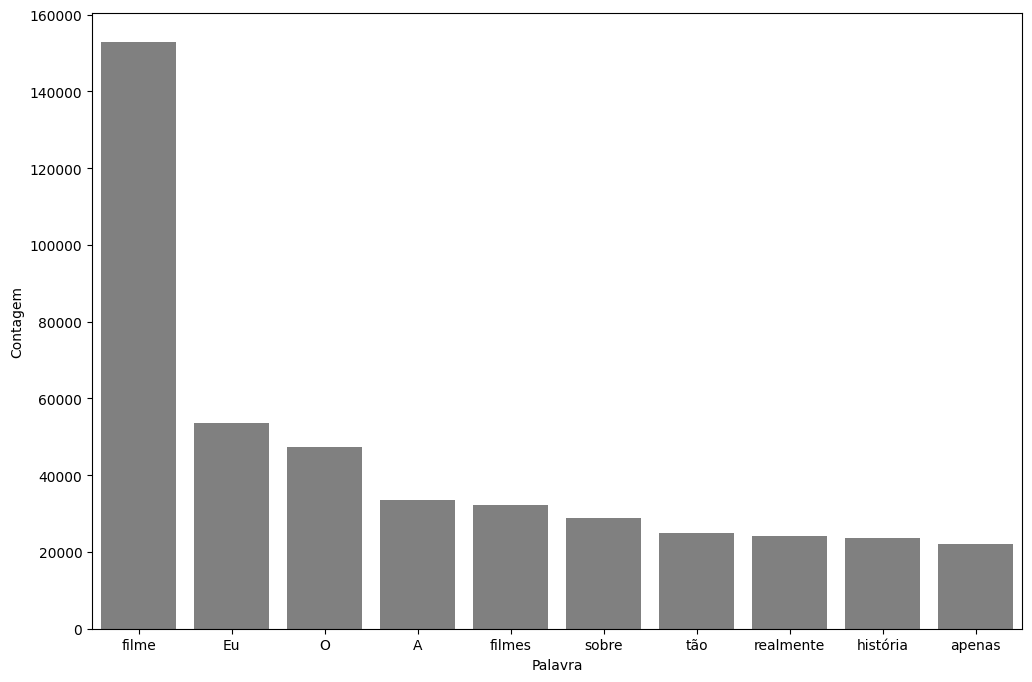

In [44]:
pareto(resenha, "tratamento_2", 10)